In [1]:
import nltk
from nltk.corpus import brown

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Nirajan\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Nirajan\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
corpus = brown.tagged_sents(tagset='universal')

In [4]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
len(corpus)

57340

In [6]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [8]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(inputs, targets, test_size=0.3)

In [9]:
# Convert sentences to sequence
MAX_VOCAB_SIZE = None

# Capatalization might be useful
should_lowercase = False

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, 
    lower=should_lowercase,
    oov_token='UNK'
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

tokenizer.fit_on_texts(X_train_)
X_train_unpadded = tokenizer.texts_to_sequences(X_train_)
X_test_unpadded = tokenizer.texts_to_sequences(X_test_)

In [10]:
# Get word - index mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

Found 47396 unique tokens.


In [11]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [12]:
all_train_targets = set(flatten(y_train_))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [13]:
all_test_targets = set(flatten(y_test_))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [14]:
all_train_targets == all_test_targets

True

In [15]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train_)
y_train = tag_tokenizer.texts_to_sequences(y_train_)
y_test = tag_tokenizer.texts_to_sequences(y_test_)

# save for later
y_train_unpadded = y_train
y_test_unpadded = y_test

In [16]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets

maxlen_train = max(len(sent) for sent in X_train_)
maxlen_test = max(len(sent) for sent in X_test_)
T = max((maxlen_train, maxlen_test))

In [17]:
# pad sequences so that we get a N x T matrix
X_train = pad_sequences(X_train_unpadded, maxlen=T)
print('Shape of data train tensor:', X_train.shape)

Shape of data train tensor: (40138, 180)


In [18]:
X_test = pad_sequences(X_test_unpadded, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

Shape of data test tensor: (17202, 180)


In [19]:
y_train = pad_sequences(y_train, maxlen=T)
print('Shape of train targets tensor:', y_train.shape)

Shape of train targets tensor: (40138, 180)


In [20]:
y_test = pad_sequences(y_test, maxlen=T)
print('Shape of test targets tensor:', y_test.shape)

Shape of test targets tensor: (17202, 180)


In [21]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

In [22]:
# Create a model

# We get to choose embedding dimensionality
D = 32

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU
x = Embedding(V+1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [23]:
# Compile and fit
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

# NOTE: you "could" speed this up by creating a custom loss, since Tensorflow's
# implementation of mask_zero currently sucks, but it's sufficiently advanced
# to be outside the scope of this course
# In my experiments, CPU is faster than GPU in all cases, and CPU for custom
# loss is faster than CPU for mask_zero

# > 300-400s per epoch on CPU
# > 30 MINUTES per epoch on GPU

r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=5
)

Epoch 1/5
1255/1255 [==============================] - 153s 117ms/step - loss: 0.0534 - accuracy: 0.8574 - val_loss: 0.0122 - val_accuracy: 0.9668
Epoch 2/5
1255/1255 [==============================] - 151s 120ms/step - loss: 0.0079 - accuracy: 0.9783 - val_loss: 0.0099 - val_accuracy: 0.9719
Epoch 3/5
1255/1255 [==============================] - 147s 117ms/step - loss: 0.0049 - accuracy: 0.9863 - val_loss: 0.0095 - val_accuracy: 0.9734
Epoch 4/5
1255/1255 [==============================] - 174s 139ms/step - loss: 0.0037 - accuracy: 0.9897 - val_loss: 0.0099 - val_accuracy: 0.9735
Epoch 5/5
1255/1255 [==============================] - 168s 134ms/step - loss: 0.0029 - accuracy: 0.9919 - val_loss: 0.0104 - val_accuracy: 0.9731


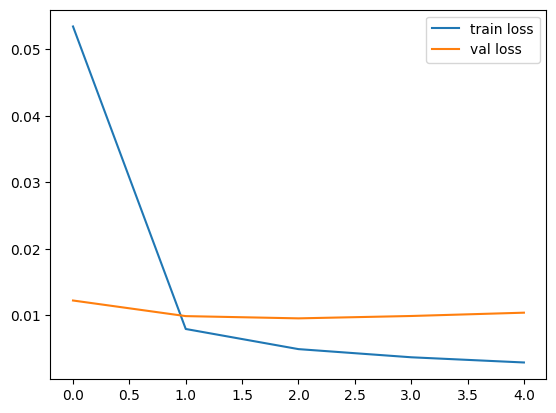

In [24]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

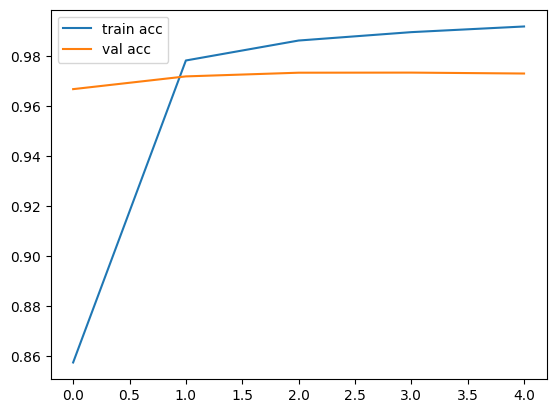

In [25]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [26]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in X_train_unpadded:
    train_lengths.append(len(sentence))

test_lengths = []
for sentence in X_test_unpadded:
    test_lengths.append(len(sentence))

In [27]:
train_probs = model.predict(X_train) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(y_train_unpadded)

1255/1255 [==============================] - 40s 30ms/step


In [28]:
test_probs = model.predict(X_test) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(y_test_unpadded)

538/538 [==============================] - 16s 29ms/step


In [29]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9942731835273206
Test acc: 0.9730879531484161
Train f1: 0.9871864039123864
Test f1: 0.9327747156804308


In [33]:
### Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [37]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(X_train_, y_train_):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [38]:
# compute accuracy

train_predictions = []
for sentence in X_train_:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(y_train_)

In [39]:
test_predictions = []
for sentence in X_test_:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(y_test_)

In [40]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9572719752292754
Test acc: 0.9276400758231674
Train f1: 0.9385902014999014
Test f1: 0.8279065434750679


In [41]:
# Exercise #1: use different layers (GRU, SimpleRNN), different number of hidden
# units, number of layers, etc. as before
# Also, repeat the exercise with CNNs instead of RNNs

In [42]:
# Exercise #2: repeat the same code, but include the 2 mistakes
# Mistake #1: not having an OOV token (target len != input len, misalignment)
#     Also, verify that target misalignment exists
# Mistake #2: not ignoring padding in loss computation
# Observe that you get 99% accuracy, even with a bad model.
# Exercise: why is the accuracy so high? (discuss on Q&A with your peers)

# I've seen these mistakes on Kaggle and on blogs (you know how I like
# to read a.k.a. judge bad DS/ML bloggers and marketers). The mistake arises
# from "trusting the library too much", assuming you can just use the
# Tokenizer() with default values and Embedding() with default values, and not
# thinking about what they actually do.

# i.e. it's important to THINK, not just "use libraries".